# Conditional GAN - MNIST

Make Your First GAN With PyTorch, 2020

In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset Class

In [2]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [3]:
# load data

mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

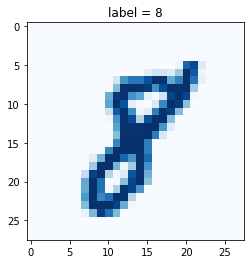

In [4]:
# check data contains images

mnist_dataset.plot_image(17)

## Data Functions

In [5]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

## Discriminator Network

In [6]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            
            nn.Linear(200, 100),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, image_tensor, label_tensor):
        # combine seed and label
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(inputs, label_tensor)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Discriminator

In [7]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 6min 10s, sys: 53.3 s, total: 7min 3s
Wall time: 5min 25s


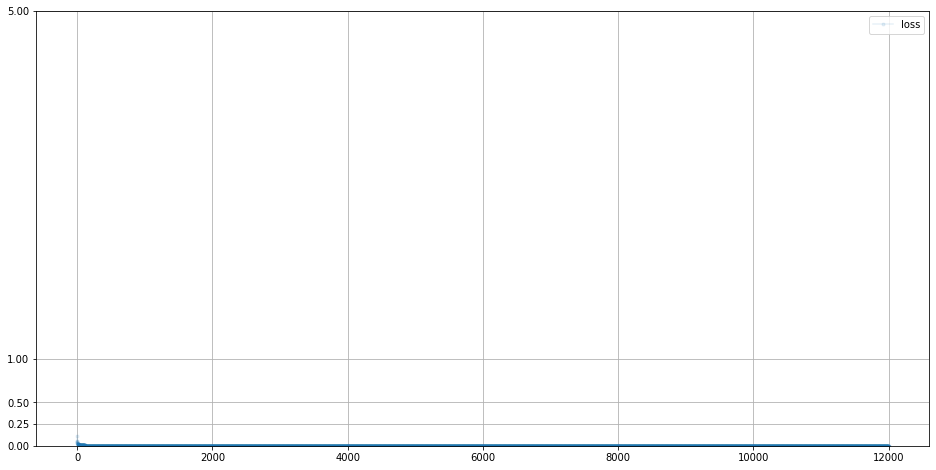

In [8]:
# plot discriminator loss

D.plot_progress()

In [9]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,60000)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784), generate_random_one_hot(10) ).item() )
  pass

1.0
1.0
1.0
1.0
1.1702875647723321e-11
1.1615148946819698e-11
1.2122502654476897e-11
1.1543128432267569e-11


## Generator Network

In [10]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),

            nn.Linear(200, 100),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(100),

            nn.Linear(100, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Generator Output

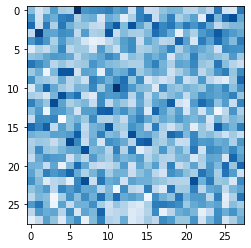

In [11]:
# check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [12]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

In [13]:
%%time 

# train Discriminator and Generator

epochs = 12

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, label_tensor in mnist_dataset:
    # train discriminator on true
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # random 1-hot label for generator
    random_label = generate_random_one_hot(10)
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    
    # different random 1-hot label for generator
    random_label = generate_random_one_hot(10)

    # train generator
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000


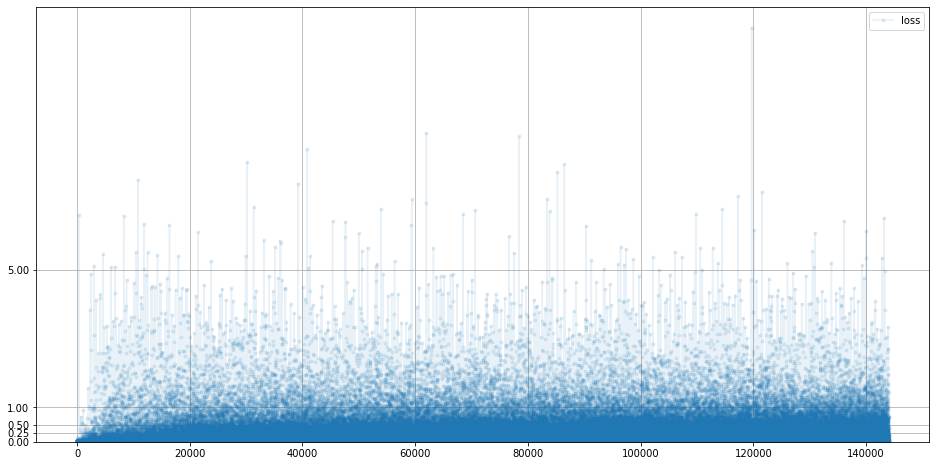

In [14]:
# plot discriminator error

D.plot_progress()

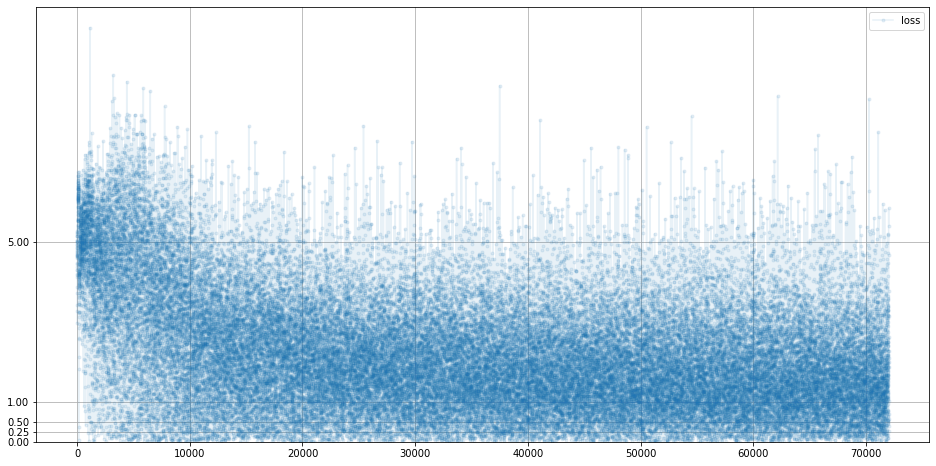

In [15]:
# plot generator error

G.plot_progress()

## Run Generator

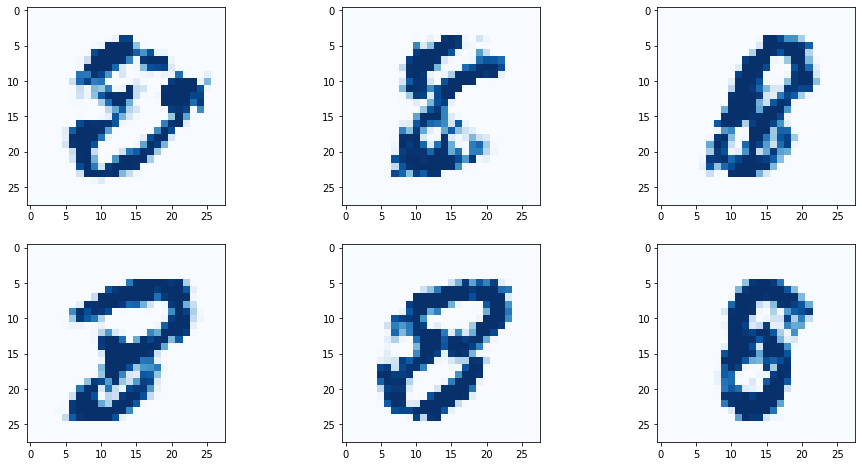

In [16]:
# plot several outputs from the trained generator

G.plot_images(8)

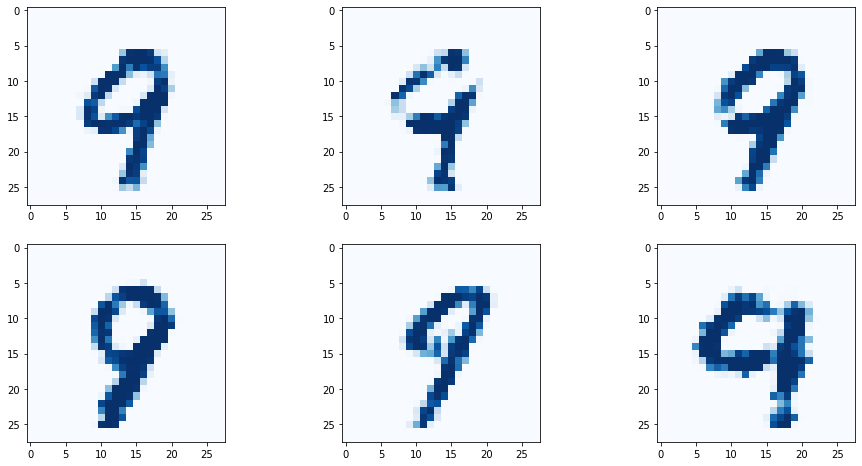

In [17]:
# plot several outputs from the trained generator

G.plot_images(9)

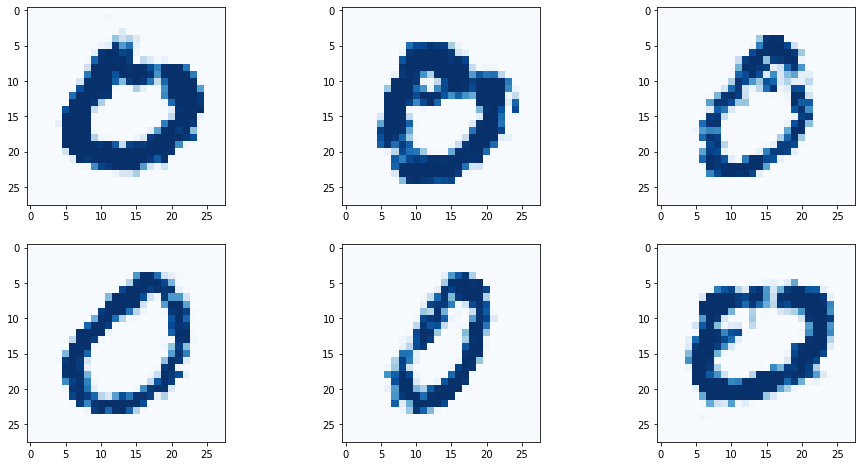

In [18]:
# plot several outputs from the trained generator

G.plot_images(0)

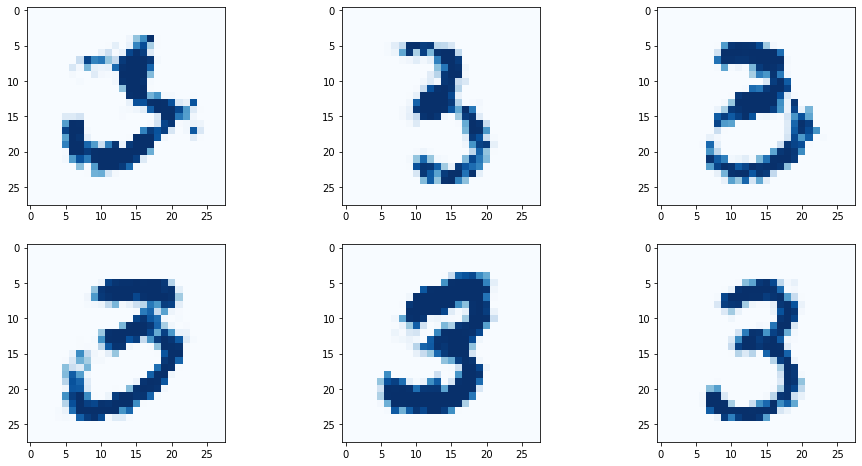

In [19]:
# plot several outputs from the trained generator

G.plot_images(3)

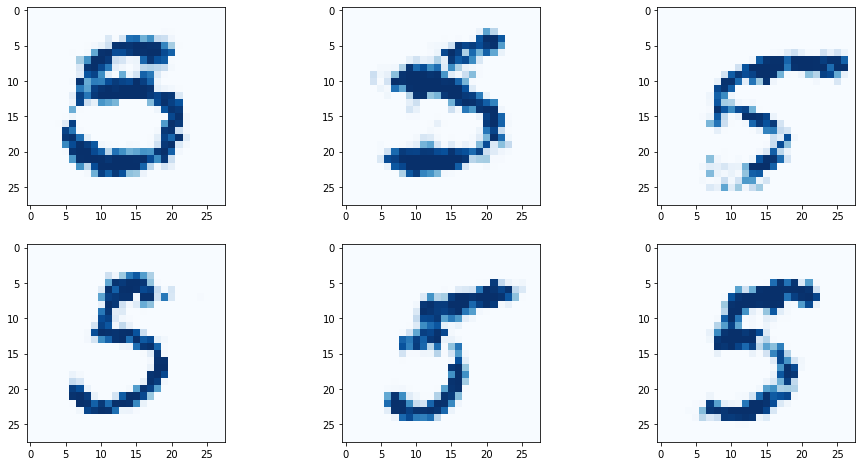

In [20]:
# plot several outputs from the trained generator

G.plot_images(5)

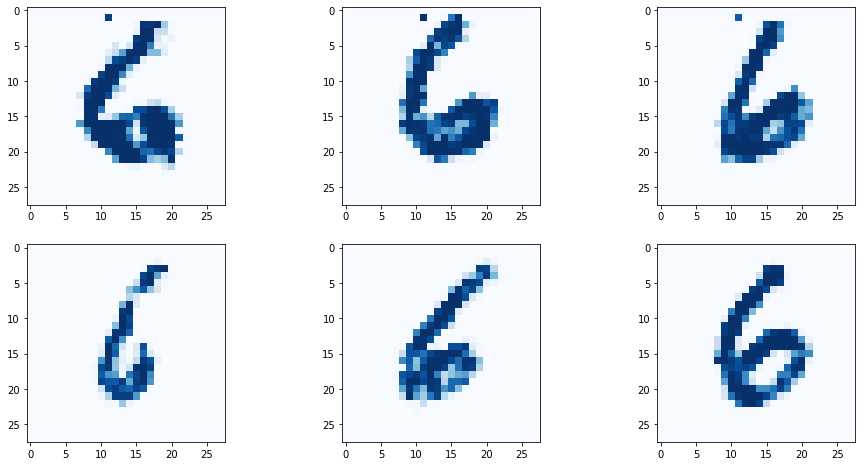

In [21]:
# plot several outputs from the trained generator

G.plot_images(6)

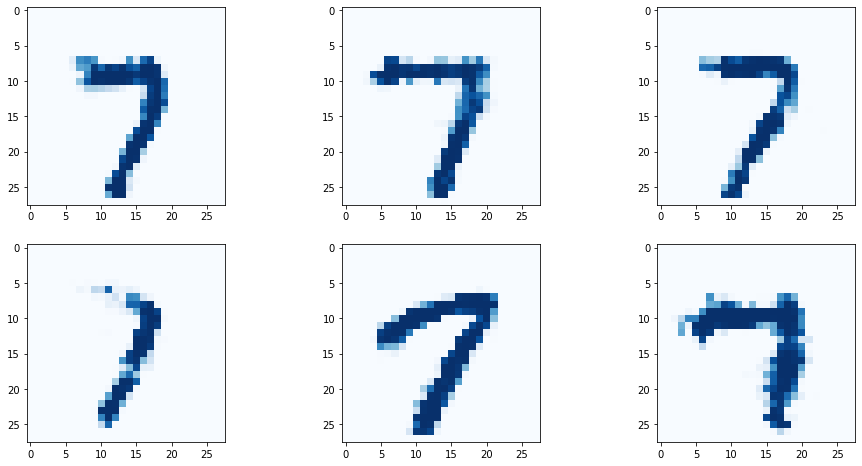

In [22]:
# plot several outputs from the trained generator

G.plot_images(7)

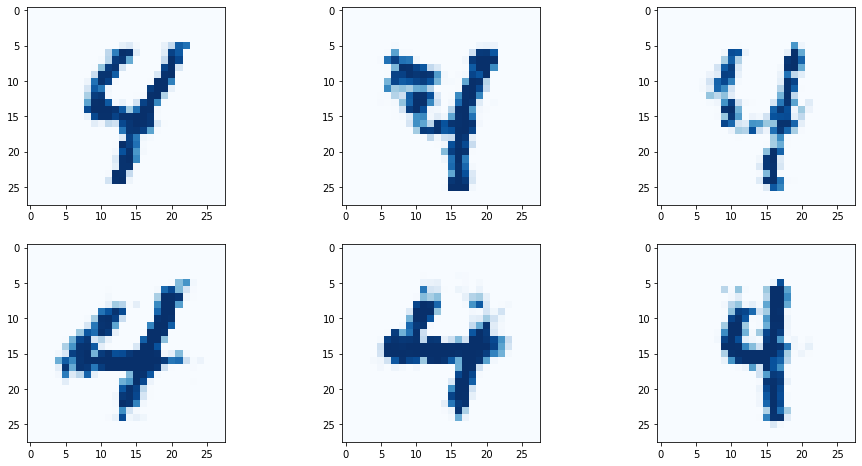

In [23]:
# plot several outputs from the trained generator

G.plot_images(4)

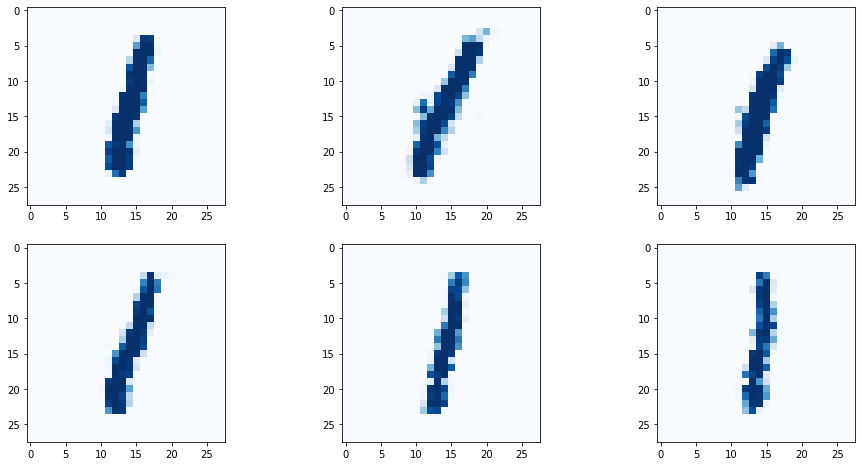

In [26]:
# plot several outputs from the trained generator

G.plot_images(1)